In [5]:
import os
import glob
import pandas as pd
from tqdm.auto import tqdm
import time
import numpy as np
import numpy.ma as ma

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Read in the data to on dictionary of each Modal

In [6]:


sensor_list = ['act', 'acw', 'dc', 'pm']
# Test out the read in helper function
def get_subject_action(sensor, full_path):
    index = full_path.find(sensor)
    index += len(sensor)
    subject = int(full_path[index+1:index+3])
    action = int(full_path[index+4:index+6])
    if action == 4:
        if full_path.find(f"{sensor}_1") > 0:
            action = '4-1'
        else:
            action = '4-2'
        
    return (subject, str(action))

for sensor in sensor_list:
    for sensor_dir in glob.iglob('.\\data\\' + sensor ):
        print(f"On {sensor}")
        for subject_id, subject_dir in enumerate(glob.iglob(f"{sensor_dir}\\*")):
            for action_id, file in enumerate(os.listdir(subject_dir)):
                full_path = f"{subject_dir}\\{file}"
                #print(full_path, get_subject_action(sensor, full_path))
                
test_str = '.\\data\\act\\01\\01_act_1.csv'
get_subject_action('act', test_str)

On act
On acw
On dc
On pm


(1, '1')

In [7]:
%%time
total_data = {
    'act': None,
    'acw': None,
    'dc': None,
    'pm': None,
}


headers = {
    'act': ['times', 'X', 'Y', 'Z'],
    'acw': ['times', 'X', 'Y', 'Z'],
    'dc': ['times'],
    'pm': ['times']
}
for i in range(1,513):
    headers['pm'].append(f"sensor_{i}")
for i in range(1,193):
    headers['dc'].append(f"sensor_{i}")

actions = ['1', '2', '3', '4-1', '4-2', '5', '6', '7']

sensor_list = ['act', 'acw', 'dc', 'pm']
#sensor_list = ['acw']

# there are 956 files in our dataset
i = 0

pbar = tqdm(desc="load data", total=956)
for sensor in sensor_list:
    for sensor_dir in glob.iglob('.\\data\\' + sensor ):
        #print(f"On {sensor}")
        for subject_id, subject_dir in enumerate(glob.iglob(f"{sensor_dir}\\*")):
            for action_id, file in enumerate(os.listdir(subject_dir)):
                full_path = f"{subject_dir}\\{file}"
                df_tmp = pd.read_csv(full_path, names=headers[sensor])
                i+=1
                pbar.update(1)
                subject, action = get_subject_action(sensor, full_path)
                # add one to make it match the given format
                df_tmp['subject'] = subject
                df_tmp['action'] = action
                if total_data[sensor] is None:
                    total_data[sensor] = df_tmp
                else:
                    total_data[sensor] = pd.concat([total_data[sensor], df_tmp])

load data:   0%|          | 0/956 [00:00<?, ?it/s]

Wall time: 1min 22s


## Show what is in each

In [8]:
for key in total_data.keys():
    if total_data[key] is not None:
        print(key)
        print(total_data[key]['action'].unique())
        print(total_data[key]['subject'].unique())
        for header in headers[key]:
            if(total_data[key][header].isnull().values.any()):
                print(f"{header} has Null data")
        print(total_data[key].info())
        print('-------------------------------------------------------------------------')

act
['1' '2' '3' '4-1' '4-2' '5' '6' '7']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1400856 entries, 0 to 6418
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   times    1400856 non-null  object 
 1   X        1400856 non-null  float64
 2   Y        1400856 non-null  float64
 3   Z        1400856 non-null  float64
 4   subject  1400856 non-null  int64  
 5   action   1400856 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 74.8+ MB
None
-------------------------------------------------------------------------
acw
['1' '2' '3' '4-1' '4-2' '5' '6' '7']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313695 entries, 0 to 6013
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  -----

In [9]:
df_acw = total_data['acw']
subject = 1
action = '1'
df_acw[(df_acw.subject == subject) & (df_acw.action == action)]

,times,X,Y,Z,subject,action
0,2018-11-08 11:34:51.474000,0.125000,-0.046875,0.90625,1,1
1,2018-11-08 11:34:51.485000,0.109375,-0.062500,0.90625,1,1
2,2018-11-08 11:34:51.495000,0.109375,-0.062500,0.90625,1,1
3,2018-11-08 11:34:51.505000,0.125000,-0.062500,0.90625,1,1
4,2018-11-08 11:34:51.516000,0.125000,-0.062500,0.90625,1,1
...,...,...,...,...,...,...
6269,2018-11-08 11:35:56.373000,0.093750,-0.265625,0.87500,1,1
6270,2018-11-08 11:35:56.383000,0.093750,-0.281250,0.87500,1,1
6271,2018-11-08 11:35:56.394000,0.093750,-0.265625,0.87500,1,1
6272,2018-11-08 11:35:56.404000,0.093750,-0.265625,0.87500,1,1


In [10]:
total_data['pm'].head()

,times,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_505,sensor_506,sensor_507,sensor_508,sensor_509,sensor_510,sensor_511,sensor_512,subject,action
0,2018-11-08 11:34:51.468000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,68.0,77.0,55.0,193.0,387.0,331.0,125.0,6.0,1,1
1,2018-11-08 11:34:51.535000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,58.0,78.0,53.0,192.0,388.0,330.0,123.0,6.0,1,1
2,2018-11-08 11:34:51.602000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,64.0,78.0,53.0,195.0,390.0,330.0,119.0,7.0,1,1
3,2018-11-08 11:34:51.669000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,66.0,79.0,55.0,196.0,391.0,324.0,106.0,5.0,1,1
4,2018-11-08 11:34:51.737000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,64.0,79.0,55.0,194.0,391.0,321.0,114.0,6.0,1,1


In [11]:
# show reshape is doing what we think
x = np.array([[1,2,3],
          [4,5,6],
          [7,8,9],
          [10,11,12],
          [13,14,15],
          [16,17,18]])
y = np.array(range(0,24))
y = np.reshape(y, (6,4))

z = np.array(range(0,30))
z = np.reshape(z, (6, 5))


np.hstack((x,y,z))

array([[ 1,  2,  3,  0,  1,  2,  3,  0,  1,  2,  3,  4],
       [ 4,  5,  6,  4,  5,  6,  7,  5,  6,  7,  8,  9],
       [ 7,  8,  9,  8,  9, 10, 11, 10, 11, 12, 13, 14],
       [10, 11, 12, 12, 13, 14, 15, 15, 16, 17, 18, 19],
       [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29]])

In [12]:
%%time
# take the total dfs and make batches for each action each subject completed
# samples100 is how many samples should be in the 100HZ (the two accleromter data)
# samples15 is how many samples from the images should be take
subjects = range(1,31)
dc_X_cols = [f"sensor_{i}" for i in range(1,193)]
pm_X_cols = [f"sensor_{i}" for i in range(1,513)]
acw_X_cols = ["X", "Y", "Z"]

def batch_data(total_dfs, seconds=5):
    samples100 = 100*seconds
    samples15 = 15*seconds
    df_acw = total_dfs['acw']
    df_act = total_dfs['act']
    df_dc = total_dfs['dc']
    df_pm = total_dfs['pm']
    
    all_cols = []
    for i in range(0, samples100):
        all_cols += [f"acw_{val}_{i}" for val in acw_X_cols]
    for i in range(0, samples15):
        all_cols += [f"dc_{val}_{i}" for val in dc_X_cols]
    for i in range(0, samples15):
        all_cols += [f"pm_{val}_{i}" for val in pm_X_cols]
    for i in range(0, samples100):
        all_cols += [f"act_{val}_{i}" for val in acw_X_cols]
    
    
    df_all = pd.DataFrame(columns=all_cols+['action'])
    
    actions = df_acw['action'].unique()
    pbar = tqdm(desc="batch data", total=len(subjects)*len(actions))
    for subject in subjects:
        actions = df_acw['action'].unique()
        for action in actions:
            X_acw = df_acw[(df_acw.subject == subject) & (df_acw.action == action)][acw_X_cols].to_numpy()
            X_acw = X_acw[range(0, (X_acw.shape[0]//samples100)*samples100)] # cut off records that don't fit in the window
            X_acw = np.reshape(X_acw, (X_acw.shape[0]//samples100, samples100*len(acw_X_cols)))
            
            X_dc = df_dc[(df_dc.subject == subject) & (df_dc.action == action)][dc_X_cols].to_numpy()
            X_dc = X_dc[range(0, (X_dc.shape[0]//samples15)*samples15)]
            X_dc = np.reshape(X_dc, (X_dc.shape[0]//samples15, samples15*len(dc_X_cols)))
            
            X_pm = df_pm[(df_pm.subject == subject) & (df_pm.action == action)][pm_X_cols].to_numpy()
            X_pm = X_pm[range(0, (X_pm.shape[0]//samples15)*samples15)]
            X_pm = np.reshape(X_pm, (X_pm.shape[0]//samples15, samples15*len(pm_X_cols)))
            
            X_act = df_act[(df_act.subject == subject) & (df_act.action == action)][acw_X_cols].to_numpy()
            X_act = X_act[range(0, (X_act.shape[0]//samples100)*samples100)]
            X_act = np.reshape(X_act, (X_act.shape[0]//samples100, samples100*len(acw_X_cols)))
            
            # trim to the smallest one of these 4
            num_records = min(X_acw.shape[0], X_act.shape[0], X_pm.shape[0], X_dc.shape[0])
            X_acw = X_acw[range(0,num_records)]
            X_dc = X_dc[range(0,num_records)]
            X_pm = X_pm[range(0,num_records)]
            X_act = X_act[range(0,num_records)]
            
            X_total = np.hstack((X_acw, X_dc, X_pm, X_act))
            
            df_tmp = pd.DataFrame(X_total, columns=all_cols)
            df_tmp['action'] = action
            df_all = pd.concat([df_all, df_tmp])
            
            pbar.update(1)
            
    return df_all

df_batched = batch_data(total_data, seconds=3)
df_batched.head()

batch data:   0%|          | 0/240 [00:00<?, ?it/s]

Wall time: 1min 24s


,acw_X_0,acw_Y_0,acw_Z_0,acw_X_1,acw_Y_1,acw_Z_1,acw_X_2,acw_Y_2,acw_Z_2,acw_X_3,...,act_X_297,act_Y_297,act_Z_297,act_X_298,act_Y_298,act_Z_298,act_X_299,act_Y_299,act_Z_299,action
0,0.125000,-0.046875,0.906250,0.109375,-0.062500,0.906250,0.109375,-0.062500,0.906250,0.125000,...,-0.640625,-0.562500,0.437500,-0.656250,-0.562500,0.468750,-0.671875,-0.578125,0.468750,1
1,0.156250,-0.062500,0.906250,0.156250,-0.062500,0.890625,0.156250,-0.062500,0.890625,0.156250,...,-0.625000,-0.796875,0.171875,-0.625000,-0.781250,0.171875,-0.625000,-0.781250,0.171875,1
2,0.218750,-0.078125,0.890625,0.218750,-0.078125,0.875000,0.234375,-0.078125,0.890625,0.234375,...,-0.593750,-0.750000,0.281250,-0.609375,-0.750000,0.296875,-0.609375,-0.750000,0.296875,1
3,0.281250,-0.093750,0.859375,0.281250,-0.093750,0.875000,0.281250,-0.093750,0.859375,0.281250,...,-0.593750,-0.734375,0.296875,-0.593750,-0.734375,0.296875,-0.593750,-0.734375,0.296875,1
4,0.359375,-0.062500,0.843750,0.359375,-0.062500,0.843750,0.359375,-0.078125,0.843750,0.359375,...,-0.593750,-0.734375,0.312500,-0.578125,-0.734375,0.312500,-0.593750,-0.734375,0.296875,1


In [13]:
df_batched.groupby('action').count()

,acw_X_0,acw_Y_0,acw_Z_0,acw_X_1,acw_Y_1,acw_Z_1,acw_X_2,acw_Y_2,acw_Z_2,acw_X_3,...,act_Z_296,act_X_297,act_Y_297,act_Z_297,act_X_298,act_Y_298,act_Z_298,act_X_299,act_Y_299,act_Z_299
action,,,,,,,,,,,,,,,,,,,,,
1,419,419,419,419,419,419,419,419,419,419,...,419,419,419,419,419,419,419,419,419,419
2,447,447,447,447,447,447,447,447,447,447,...,447,447,447,447,447,447,447,447,447,447
3,449,449,449,449,449,449,449,449,449,449,...,449,449,449,449,449,449,449,449,449,449
4-1,226,226,226,226,226,226,226,226,226,226,...,226,226,226,226,226,226,226,226,226,226
4-2,198,198,198,198,198,198,198,198,198,198,...,198,198,198,198,198,198,198,198,198,198
5,427,427,427,427,427,427,427,427,427,427,...,427,427,427,427,427,427,427,427,427,427
6,398,398,398,398,398,398,398,398,398,398,...,398,398,398,398,398,398,398,398,398,398
7,441,441,441,441,441,441,441,441,441,441,...,441,441,441,441,441,441,441,441,441,441


# Stick the data into a net

In [14]:
seconds = 3
samples100 = 100*seconds
samples15 = 15*seconds

all_cols = []
for i in range(0, samples100):
    all_cols += [f"acw_{val}_{i}" for val in acw_X_cols]
for i in range(0, samples15):
    all_cols += [f"dc_{val}_{i}" for val in dc_X_cols]
for i in range(0, samples15):
    all_cols += [f"pm_{val}_{i}" for val in pm_X_cols]
for i in range(0, samples100):
    all_cols += [f"act_{val}_{i}" for val in acw_X_cols]

In [15]:
X = df_batched[all_cols].to_numpy()
X.shape

(3005, 33480)

In [16]:
df_y = pd.get_dummies(df_batched.action, prefix='action_ohe')
y = df_y.to_numpy()
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

### Train test split real quick

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [18]:
from tensorflow.keras.layers import Dense, Activation, Input, GRU, SimpleRNN, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform

def get_combined_model():
    input_all = Input(shape=(X.shape[1],))
    x = Dense(units=2048, activation='sigmoid',kernel_initializer='random_normal')(input_all)
    x = Dense(units=1024, activation='sigmoid',kernel_initializer='random_normal')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=512, activation='sigmoid',kernel_initializer='random_normal')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=512, activation='tanh',kernel_initializer='random_normal')(x)
    x = Dropout(0.3)(x)
    x = Dense(units=512, activation='tanh',kernel_initializer='random_normal')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=512, activation='tanh',kernel_initializer='random_normal')(x)
    prediction = Dense(units=8, activation='softmax')(x)

    model = Model(inputs=input_all, outputs=prediction)
    return model

In [19]:
from tensorflow.keras.optimizers import Adam
model = get_combined_model()
model.compile(optimizer=Adam(learning_rate=0.000001, beta_1=0.99, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 33480)]           0         
_________________________________________________________________
dense (Dense)                (None, 2048)              68569088  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656

In [20]:
%%time
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200,  batch_size=10)

Train on 2404 samples, validate on 601 samples
Epoch 1/200
2404/2404 [==============================] - 5s 2ms/sample - loss: 2.2838 - accuracy: 0.1331 - val_loss: 2.0574 - val_accuracy: 0.1464
Epoch 2/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 2.2493 - accuracy: 0.1485 - val_loss: 2.0255 - val_accuracy: 0.1597
Epoch 3/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 2.2334 - accuracy: 0.1402 - val_loss: 2.0164 - val_accuracy: 0.1614
Epoch 4/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 2.2151 - accuracy: 0.1498 - val_loss: 2.0080 - val_accuracy: 0.2246
Epoch 5/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 2.1825 - accuracy: 0.1577 - val_loss: 2.0022 - val_accuracy: 0.2579
Epoch 6/200
2404/2404 [==============================] - 4s 2ms/sample - loss: 2.1848 - accuracy: 0.1585 - val_loss: 1.9948 - val_accuracy: 0.3028
Epoch 7/200
2404/2404 [==============================] - 4s 2ms/sample 

2404/2404 [==============================] - 3s 1ms/sample - loss: 1.7752 - accuracy: 0.3557 - val_loss: 1.4983 - val_accuracy: 0.6073
Epoch 57/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 1.7629 - accuracy: 0.3473 - val_loss: 1.4833 - val_accuracy: 0.6123
Epoch 58/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 1.7473 - accuracy: 0.3623 - val_loss: 1.4688 - val_accuracy: 0.6206
Epoch 59/200
2404/2404 [==============================] - 4s 2ms/sample - loss: 1.7494 - accuracy: 0.3619 - val_loss: 1.4548 - val_accuracy: 0.6156
Epoch 60/200
2404/2404 [==============================] - 4s 2ms/sample - loss: 1.7315 - accuracy: 0.3669 - val_loss: 1.4399 - val_accuracy: 0.6173
Epoch 61/200
2404/2404 [==============================] - 4s 2ms/sample - loss: 1.7065 - accuracy: 0.3802 - val_loss: 1.4248 - val_accuracy: 0.6206
Epoch 62/200
2404/2404 [==============================] - 4s 2ms/sample - loss: 1.7120 - accuracy: 0.3702 - val_loss: 1.4101 

2404/2404 [==============================] - 3s 1ms/sample - loss: 0.6676 - accuracy: 0.7704 - val_loss: 0.6473 - val_accuracy: 0.7754
Epoch 167/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 0.6784 - accuracy: 0.7646 - val_loss: 0.6439 - val_accuracy: 0.7787
Epoch 168/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 0.6484 - accuracy: 0.7870 - val_loss: 0.6414 - val_accuracy: 0.7787
Epoch 169/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 0.6609 - accuracy: 0.7779 - val_loss: 0.6396 - val_accuracy: 0.7770
Epoch 170/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 0.6483 - accuracy: 0.7762 - val_loss: 0.6340 - val_accuracy: 0.7937
Epoch 171/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 0.6474 - accuracy: 0.7750 - val_loss: 0.6300 - val_accuracy: 0.7920
Epoch 172/200
2404/2404 [==============================] - 3s 1ms/sample - loss: 0.6238 - accuracy: 0.7845 - val_loss: 0

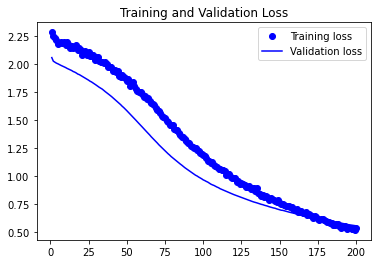

In [21]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [22]:


yhat = model.predict(X_train)
yhat = np.argmax(yhat, axis=1)
y_train_actual = np.argmax(y_train, axis=1)
print('Train:', accuracy_score(y_train_actual, yhat)*100)

yhat = model.predict(X_test)
yhat = np.argmax(yhat, axis=1)
y_test_actual = np.argmax(y_test, axis=1)
print('Validation:', accuracy_score(y_test_actual, yhat)*100)

Train: 89.97504159733776
Validation: 81.19800332778702


In [23]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

In [155]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12.8,4.8))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
%%time
folds = StratifiedKFold(n_splits=4, shuffle=True)
y_actual = np.argmax(y, axis=1)
for index, (train_indices, val_indices) in enumerate(folds.split(X, y_actual)):
    model = get_combined_model()
    # TODO: move this to the model def.
    model.compile(optimizer=Adam(learning_rate=0.000001, beta_1=0.99, beta_2=0.999),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(X[train_indices], y[train_indices],
                        validation_data=(X[val_indices], y[val_indices]),
                        epochs=175,  batch_size=10, verbose=False)
    yhat = model.predict(X[train_indices])
    yhat = np.argmax(yhat, axis=1)
    y_train_actual = np.argmax(y[train_indices], axis=1)
    print(f"Fold {index}")
    print('Train:', accuracy_score(y_train_actual, yhat)*100)

    yhat = model.predict(X[val_indices])
    yhat = np.argmax(yhat, axis=1)
    y_test_actual = np.argmax(y[val_indices], axis=1)
    print('Validation:', accuracy_score(y_test_actual, yhat)*100)
    
    plot_history(history)

In [26]:
# TODO: Change this to be saved from above.

vals = np.array([77.3635153129161, 74.30093209054593, 79.22769640479362, 76.72872340425532])
np.mean(vals)

76.90521680312774

# Lets play with making a multi modal model

In [34]:
df_batched.columns

Index(['acw_X_0', 'acw_Y_0', 'acw_Z_0', 'acw_X_1', 'acw_Y_1', 'acw_Z_1',
       'acw_X_2', 'acw_Y_2', 'acw_Z_2', 'acw_X_3',
       ...
       'act_X_297', 'act_Y_297', 'act_Z_297', 'act_X_298', 'act_Y_298',
       'act_Z_298', 'act_X_299', 'act_Y_299', 'act_Z_299', 'action'],
      dtype='object', length=33481)

In [35]:
# we have 300 different x,y,z's for each acc

#wrist data
acw_X_cols_batched = []
for j in range(0, samples100):
    acw_X_cols_batched += [f"acw_{val}_{j}" for val in acw_X_cols]
X_acw_batched = df_batched[acw_X_cols_batched].to_numpy()

# thigh data
act_X_cols_batched = []
for j in range(0, samples100):
    act_X_cols_batched += [f"act_{val}_{j}" for val in acw_X_cols]
X_act_batched = df_batched[acw_X_cols_batched].to_numpy()

# Depth Camera data
dc_X_cols_batched = []
for j in range(0, samples15):
    dc_X_cols_batched += [f"dc_{val}_{j}" for val in dc_X_cols]
X_dc_batched = df_batched[dc_X_cols_batched].to_numpy()
    
# Pressure Mat data
pm_X_cols_batched = []
for j in range(0, samples15):
    pm_X_cols_batched += [f"pm_{val}_{j}" for val in pm_X_cols]
X_pm_batched = df_batched[pm_X_cols_batched].to_numpy()
len(pm_X_cols_batched)

23040

## split for tuning


In [91]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_act_batched_train, X_act_batched_test, \
X_acw_batched_train, X_acw_batched_test, \
X_dc_batched_train, X_dc_batched_test, \
X_pm_batched_train, X_pm_batched_test, \
y_train, y_test = \
train_test_split(X_act_batched, X_acw_batched, X_dc_batched, X_pm_batched, y, 
                 test_size=0.2, shuffle=True)

print(X_act_batched_train.shape)
print(X_act_batched_test.shape)
print(X_acw_batched_train.shape)
print(X_acw_batched_test.shape)
print(X_dc_batched_train.shape)
print(X_dc_batched_test.shape)
print(X_pm_batched_train.shape)
print(X_pm_batched_test.shape)
print(y_train.shape)
print(y_test.shape)

(2404, 900)
(601, 900)
(2404, 900)
(601, 900)
(2404, 8640)
(601, 8640)
(2404, 23040)
(601, 23040)
(2404, 8)
(601, 8)


In [92]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6, skip=0, step=1):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row *2))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[(i * step) + skip],cmap='bone')
    plt.show()


### Reshape the pressure mat back into images

(2404, 45, 32, 16)


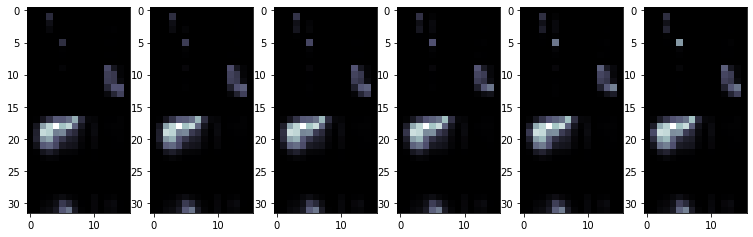

In [132]:
print(X_pm_batched_train.shape)
X_pm_batched_train = X_pm_batched_train.reshape(X_pm_batched_train.shape[0],45,32,16)
X_pm_batched_test = X_pm_batched_test.reshape(X_pm_batched_test.shape[0],45,32,16)

plot_gallery(X_pm_batched_test[16], [1,2,3],32,16,1,6)

### Reshape the depth camera back into images 

(2404, 45, 32, 16)


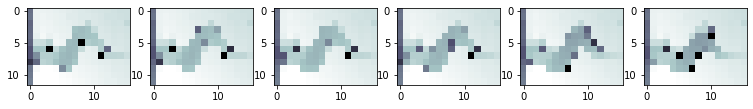

In [135]:
print(X_pm_batched_train.shape)
X_dc_batched_train = X_dc_batched_train.reshape(X_dc_batched_train.shape[0],45,12,16)
X_dc_batched_test = X_dc_batched_test.reshape(X_dc_batched_test.shape[0],45,12,16)

plot_gallery(X_dc_batched_test[16], [1,2,3],16,12,1,6)

In [94]:
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

In [140]:
# https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
input_thigh = Input(shape=(X_act_batched.shape[1],))
input_wrist = Input(shape=(X_acw_batched.shape[1],))
input_dc = Input(shape=(X_dc_batched_train.shape[1],
                        X_dc_batched_train.shape[2],
                        X_dc_batched_train.shape[3],))
input_pm = Input(shape=(X_pm_batched_train.shape[1],
                        X_pm_batched_train.shape[2],
                        X_pm_batched_train.shape[3],))

# Build some layers for the thigh
thigh = Dense(512, activation="sigmoid")(input_thigh)
thigh = Dense(256, activation="sigmoid")(thigh)
thigh = Dropout(0.1)(thigh)
thigh = Dense(128)(thigh)
thigh = Model(inputs=input_thigh, outputs=thigh)

# Build some layers for the wrist
wrist = Dense(512, activation="sigmoid")(input_wrist)
wrist = Dense(256, activation="sigmoid")(wrist)
wrist = Dropout(0.1)(wrist)
wrist = Dense(128)(wrist)
wrist = Model(inputs=input_wrist, outputs=wrist)

# Build some layers for the depth camera
# but this time we will use conv2D
dc_tens = Conv2D(filters=filt_layers[0], 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu',
                            data_format="channels_first",
                            input_shape=(X_dc_batched_train.shape[1],
                                         X_dc_batched_train.shape[2],
                                         X_dc_batched_train.shape[3]))(input_dc)
dc_tens = Conv2D(filters=filt_layers[1], 
                        kernel_size=(3,3), 
                        padding='same', 
                        activation='relu',
                        data_format="channels_first")(dc_tens)

dc_tens = Conv2D(filters=filt_layers[2], 
                        kernel_size=(3,3), 
                        padding='same', 
                        activation='relu',
                        data_format="channels_first")(dc_tens)
dc_tens = MaxPooling2D(pool_size=(2, 2), data_format="channels_first")(dc_tens)
dc_tens = Dropout(0.4) (dc_tens)
dc_tens = Flatten()(dc_tens)
dc_tens = Dense(256)(dc_tens)
dc_tens = Dropout(0.2) (dc_tens)
dc_tens = Model(inputs=input_dc, outputs=dc_tens)


# Build some layers for the pressure mat
filt_layers = [64, 32, 16]
pm_tens = Conv2D(filters=filt_layers[0], 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu',
                            data_format="channels_first",
                            input_shape=(X_pm_batched_train.shape[1],
                                         X_pm_batched_train.shape[2],
                                         X_pm_batched_train.shape[3]))(input_pm)
pm_tens = Conv2D(filters=filt_layers[1], 
                        kernel_size=(3,3), 
                        padding='same', 
                        activation='relu',
                        data_format="channels_first")(pm_tens)

pm_tens = Conv2D(filters=filt_layers[2], 
                        kernel_size=(3,3), 
                        padding='same', 
                        activation='relu',
                        data_format="channels_first")(pm_tens)
pm_tens = MaxPooling2D(pool_size=(2, 2), data_format="channels_first")(pm_tens)
pm_tens = Dropout(0.4) (pm_tens)
pm_tens = Flatten()(pm_tens)
pm_tens = Dense(256)(pm_tens)
pm_tens = Dropout(0.2) (pm_tens)
pm_tens = Model(inputs=input_pm, outputs=pm_tens)


combined = concatenate([thigh.output, wrist.output, dc_tens.output, pm_tens.output])

# Now lets run some more dense layers
last = Dense(128, activation="tanh")(combined)
last = Dropout(0.3)(last)
last = Dense(64, activation="tanh")(combined)
prediction = Dense(units=8, activation='softmax')(last)

model = Model(inputs=[thigh.input, wrist.input, dc_tens.input, pm_tens.input], outputs=prediction)



In [141]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model_93"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_100 (InputLayer)          [(None, 45, 12, 16)] 0                                            
__________________________________________________________________________________________________
input_101 (InputLayer)          [(None, 45, 32, 16)] 0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 64, 12, 16)   25984       input_100[0][0]                  
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 64, 32, 16)   25984       input_101[0][0]                  
___________________________________________________________________________________________

In [142]:
X_pm_batched_test.shape

(601, 45, 32, 16)

In [143]:
%%time
history = model.fit(x=[X_act_batched_train, X_acw_batched_train, X_dc_batched_train, X_pm_batched_train],
                    y=y_train, 
                    validation_data=(
                        [X_act_batched_test,
                         X_acw_batched_test,X_dc_batched_test, X_pm_batched_test], y_test),
                    epochs=300,  batch_size=10)

Train on 2404 samples, validate on 601 samples
Epoch 1/300
2404/2404 [==============================] - 3s 1ms/sample - loss: 2.5428 - accuracy: 0.1601 - val_loss: 2.2936 - val_accuracy: 0.2097
Epoch 2/300
2404/2404 [==============================] - 2s 632us/sample - loss: 2.2956 - accuracy: 0.2176 - val_loss: 2.0448 - val_accuracy: 0.2879
Epoch 3/300
2404/2404 [==============================] - 2s 627us/sample - loss: 2.1462 - accuracy: 0.2554 - val_loss: 1.8380 - val_accuracy: 0.3161
Epoch 4/300
2404/2404 [==============================] - 2s 635us/sample - loss: 2.0527 - accuracy: 0.2770 - val_loss: 1.7303 - val_accuracy: 0.3478
Epoch 5/300
2404/2404 [==============================] - 2s 633us/sample - loss: 1.9320 - accuracy: 0.3174 - val_loss: 1.6415 - val_accuracy: 0.3943
Epoch 6/300
2404/2404 [==============================] - 2s 633us/sample - loss: 1.8635 - accuracy: 0.3473 - val_loss: 1.5916 - val_accuracy: 0.4160
Epoch 7/300
2404/2404 [==============================] - 2s 6

2404/2404 [==============================] - 2s 626us/sample - loss: 0.6147 - accuracy: 0.7941 - val_loss: 0.4884 - val_accuracy: 0.8253
Epoch 110/300
2404/2404 [==============================] - 2s 631us/sample - loss: 0.6083 - accuracy: 0.7920 - val_loss: 0.4868 - val_accuracy: 0.8220
Epoch 111/300
2404/2404 [==============================] - 2s 624us/sample - loss: 0.6187 - accuracy: 0.7824 - val_loss: 0.4980 - val_accuracy: 0.8220
Epoch 112/300
2404/2404 [==============================] - 2s 628us/sample - loss: 0.6063 - accuracy: 0.7858 - val_loss: 0.4943 - val_accuracy: 0.8270
Epoch 113/300
2404/2404 [==============================] - 2s 628us/sample - loss: 0.5979 - accuracy: 0.7999 - val_loss: 0.4884 - val_accuracy: 0.8386
Epoch 114/300
2404/2404 [==============================] - 2s 638us/sample - loss: 0.6008 - accuracy: 0.7983 - val_loss: 0.4931 - val_accuracy: 0.8369
Epoch 115/300
2404/2404 [==============================] - 2s 626us/sample - loss: 0.5992 - accuracy: 0.7945

2404/2404 [==============================] - 2s 629us/sample - loss: 0.3271 - accuracy: 0.8910 - val_loss: 0.2791 - val_accuracy: 0.8918
Epoch 218/300
2404/2404 [==============================] - 2s 628us/sample - loss: 0.3216 - accuracy: 0.8993 - val_loss: 0.2798 - val_accuracy: 0.8985
Epoch 219/300
2404/2404 [==============================] - 2s 634us/sample - loss: 0.3130 - accuracy: 0.9006 - val_loss: 0.2794 - val_accuracy: 0.8918
Epoch 220/300
2404/2404 [==============================] - 2s 638us/sample - loss: 0.3180 - accuracy: 0.8973 - val_loss: 0.2826 - val_accuracy: 0.8935
Epoch 221/300
2404/2404 [==============================] - 2s 630us/sample - loss: 0.3207 - accuracy: 0.8968 - val_loss: 0.2701 - val_accuracy: 0.9002
Epoch 222/300
2404/2404 [==============================] - 2s 629us/sample - loss: 0.3053 - accuracy: 0.8943 - val_loss: 0.2770 - val_accuracy: 0.8952
Epoch 223/300
2404/2404 [==============================] - 2s 628us/sample - loss: 0.3132 - accuracy: 0.8918

Validation: 92.17970049916805


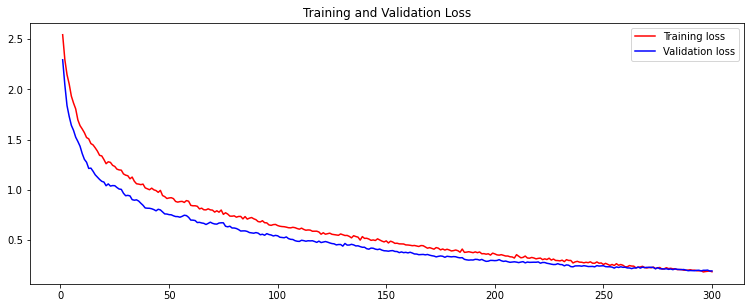

In [156]:
yhat = model.predict([X_act_batched_test, X_acw_batched_test, X_dc_batched_test, X_pm_batched_test])
yhat = np.argmax(yhat, axis=1)
y_test_actual = np.argmax(y_test, axis=1)
print('Validation:', accuracy_score(y_test_actual, yhat)*100)

plot_history(history)